## Load in Packages

In [1]:
suppressPackageStartupMessages({ 
    library(data.table) 
    library(dplyr) 
    library(ggplot2) 
    library(SingleCellExperiment)
    library(dplyr)
    library(celldex)
    library(SingleR)
    library(RColorBrewer)
    library(scater) 
    library(StabMap) 
    library(scran) 
    library(harmony) 
    library(patchwork)
    library(Seurat)
    library(plotly)
    library(pheatmap)
    library(batchelor)
    library(ggpubr)
    library(cowplot)
    library(viridis)
    library(ggplot2)
    library(cowplot)
    library(grid)
    library(ragg) # For rasterized output
    library(ggplot2)
    library(Seurat)
    library(patchwork)
    library(cowplot)
    library(ragg)
    library(gridExtra)
    library(ggplot2)
    library(patchwork)
    library(Cairo)
    library(grid)
    library(png)
})

## Load in R Scripts that Contain Cell Type Colours Etc.

In [2]:
script_files <- list.files("projects/03_seqFISH_FINAL/code/CELL_GENOMICS_REVISIONS/R_scripts", 
                           pattern = "\\.[rR]$", full.names = TRUE)

invisible(lapply(script_files, source))

## Data Locations

In [3]:
##### Load in Seurat Objects for post QC analyses #####

io = list()
io$main = "/rds/project/rds-SDzz0CATGms/users/ltgh2" # this is the main directory

# Set the working directory
setwd(io$main)

io$atlas = file.path(io$main, "projects/03_seqFISH_FINAL/code/extended_atlas_integration/processed_downsampled/downsample_10K_within_timpoint_all_stages.Rds")
io$seqFISH = file.path(io$main, "projects/03_seqFISH_FINAL/code/seqFISH_integration/processed/seqFISH_after_QC_filtering_within_and_across_dataset_integration_without_neighbour_features_E6_7_8.Rds") 

##### Load in StabMAP_Outputs #####
io$StabMAP_reweighted_MNNcorrected_original_counts_without_neigh = file.path(io$main, "projects/03_seqFISH_FINAL/code/stab_map_all_together_post_QC/output/StabMAP_allstages_postQC_reweighted_MNNcorrected_original_counts_without_neigh.Rds")
io$StabMAP_reweighted_MNNcorrected_integrated_counts_without_neigh = file.path(io$main, "projects/03_seqFISH_FINAL/code/stab_map_all_together_post_QC/output/StabMAP_allstages_postQC_reweighted_MNNcorrected_integrated_counts_without_neigh.Rds")

## Load in the seqFISH CellType Labels
io$seqFISH_labels = file.path(io$main, 
                              "projects/03_seqFISH_FINAL/code/stabmap_label_transfer/output/StabMAP_all_stages_post_QC_reweighted_MNNcorrected_original_counts_without_neigh_LABELS.Rds")

## Load in the seqFISH Imputed Gene Expression
io$seqFISH_imputed_logcounts_e6 = file.path(io$main, 
                              "projects/03_seqFISH_FINAL/code/stabmap_imputation/output/seqFISH_e6_postQC_imputed_RNA.Rds")

io$seqFISH_imputed_logcounts_e7 = file.path(io$main, 
                              "projects/03_seqFISH_FINAL/code/stabmap_imputation/output/seqFISH_e7_postQC_imputed_RNA.Rds")

io$seqFISH_imputed_logcounts_e8_1 = file.path(io$main, 
                              "projects/03_seqFISH_FINAL/code/stabmap_imputation/output/seqFISH_e8_embryo1_postQC_imputed_RNA.Rds")

io$seqFISH_imputed_logcounts_e8_2 = file.path(io$main, 
                              "projects/03_seqFISH_FINAL/code/stabmap_imputation/output/seqFISH_e8_embryo2_postQC_imputed_RNA.Rds")

io$seqFISH_imputed_logcounts_e8_3 = file.path(io$main, 
                              "projects/03_seqFISH_FINAL/code/stabmap_imputation/output/seqFISH_e8_embryo3_postQC_imputed_RNA.Rds")

## Load in the seqFISH UMAP coordinates
io$UMAP_coordinates = file.path(io$main, 
                               "projects/03_seqFISH_FINAL/code/stab_map_umap_generation/processed/StabMAP_allstage_postQC_MNNoriginal_UMAP.rds")

In [4]:
io$seqFISH_preQC = file.path(io$main, "projects/03_seqFISH_FINAL/code/seqFISH_integration/processed/seqFISH_within_and_across_dataset_integration_without_neighbour_features_E6_7_8.Rds") 

In [5]:
##### Load in within timepoint integrated Seurat Objects for pre and post QC analyses #####
io$timepoint_pre_QC = file.path(io$main, 
                               "projects/03_seqFISH_FINAL/code/seqFISH_integration/processed/seqFISH_within_dataset_integration_without_neighbour_features_E6_7_8.Rds")

io$timepoint_post_QC = file.path(io$main, 
                               "projects/03_seqFISH_FINAL/code/seqFISH_integration/processed/seqFISH_after_QC_filtering_within_dataset_integration_without_neighbour_features_E6_7_8.Rds")

In [6]:
##### Load in within timepoint integrated Seurat Objects for pre and post QC analyses #####
io$post_QC_early_embryos_ONLY = file.path(io$main, 
                               "projects/03_seqFISH_FINAL/code/seqFISH_integration/processed/seqFISH_after_QC_filtering_within_and_across_dataset_integration_without_neighbour_features_E6_7_ONLY.Rds")

In [7]:
##### Load in the refined annotations and final metadata #####
io$FINAL_REFINED_ANNOTATIONS = file.path(io$main, 
                               "projects/03_seqFISH_FINAL/code/CELL_GENOMICS_REVISIONS/outputs/1B_FINAL_REFINED_ANNOTATIONS_REVISIONS_POST_REVISION.Rds")

## Load in Seurat Objects and to the Seurat Object add the StabMAP UMAP, Transferred Cell Type Labels and Imputed Gene Expression Matrix

In [8]:
# Load in the seqFISH object_postQC
seqFISH = readRDS(io$seqFISH)

# Load in celltype, stage and anatomy labels
seqFISH_labels = readRDS(io$seqFISH_labels)

# Update the colnames in the seqFISH meta.data
seqFISH_labels_updated <- seqFISH_labels
colnames(seqFISH_labels_updated) <- c("nearest_cell_label_transfer", "celltype_extended_atlas", "stage", "anatomy", "somite_count")


seqFISH <- AddMetaData(seqFISH, metadata = seqFISH_labels_updated)

# Load in the imputed gene expression 
seqFISH_imputed_logcounts_e6 = readRDS(io$seqFISH_imputed_logcounts_e6)
seqFISH_imputed_logcounts_e7 = readRDS(io$seqFISH_imputed_logcounts_e7)
seqFISH_imputed_logcounts_e8_1 = readRDS(io$seqFISH_imputed_logcounts_e8_1)
seqFISH_imputed_logcounts_e8_2 = readRDS(io$seqFISH_imputed_logcounts_e8_2)
seqFISH_imputed_logcounts_e8_3 = readRDS(io$seqFISH_imputed_logcounts_e8_3)

# Create a combined matrix of gene expression across all time points
imputed_expression <- cbind(seqFISH_imputed_logcounts_e6$scRNA.RNA, 
                           seqFISH_imputed_logcounts_e7$scRNA.RNA, 
                            seqFISH_imputed_logcounts_e8_1$scRNA.RNA, 
                            seqFISH_imputed_logcounts_e8_2$scRNA.RNA, 
                            seqFISH_imputed_logcounts_e8_3$scRNA.RNA)

# Creat a new assay object to store imputed data
imp <- CreateAssayObject(data = imputed_expression)

# add this assay to the previously created Seurat object
seqFISH[["imputed"]] <- imp

seqFISH_postQC <- seqFISH

seqFISH_postQC

An object of class Seurat 
28723 features across 63188 samples within 4 assays 
Active assay: across_timepoint_integration (351 features, 351 variable features)
 3 other assays present: originalexp, within_timepoint_integration, imputed
 5 dimensional reductions calculated: pca, umap, spatial, Shila_PCA, Shila_UMAP

In [9]:
post_QC_early_embryos_ONLY <- readRDS(io$post_QC_early_embryos_ONLY)

In [10]:
seqFISH_preQC = readRDS(io$seqFISH_preQC)

In [11]:
seqFISH_preQC

An object of class Seurat 
1053 features across 73470 samples within 3 assays 
Active assay: across_timepoint_integration (351 features, 351 variable features)
 2 other assays present: originalexp, within_timepoint_integration
 5 dimensional reductions calculated: pca, umap, spatial, Shila_PCA, Shila_UMAP

In [12]:
# Load in the UMAP coordinates
UMAP_coordinates = readRDS(io$UMAP_coordinates)

# Load in the StabMAP coordinates
StabMAP_reweighted_MNNcorrected_original_counts_without_neigh = readRDS(io$StabMAP_reweighted_MNNcorrected_original_counts_without_neigh)

##Create dimension reduced objects to insert into the seuart object
StabMAP_original <- CreateDimReducObject(embeddings = StabMAP_reweighted_MNNcorrected_original_counts_without_neigh, 
                                         key = "StabMap.original",
                                         assay = "originalexp")

Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from StabMap.original to StabMaporiginal_”
Warning message:
“All keys should be one or more alphanumeric characters followed by an underscore '_', setting key to StabMaporiginal_”


In [13]:
# load in the final refined_annotations
FINAL_REFINED_ANNOTATIONS_UPDATED = readRDS(io$FINAL_REFINED_ANNOTATIONS)

In [14]:
FINAL_REFINED_ANNOTATIONS <- FINAL_REFINED_ANNOTATIONS_UPDATED %>% 
  select(-embryo)

In [15]:
colnames(FINAL_REFINED_ANNOTATIONS)

[1] "cell_ID"                                             
 [2] "orig.ident"                                          
 [3] "nCount_RNA"                                          
 [4] "nFeature_RNA"                                        
 [5] "seqFISH_celltype"                                    
 [6] "extended_atlas_celltype"                             
 [7] "AP"                                                  
 [8] "DV"                                                  
 [9] "dataset"                                             
[10] "cluster"                                             
[11] "subcluster"                                          
[12] "cluster_subcluster"                                  
[13] "stage"                                               
[14] "anatomy"                                             
[15] "UMAP_1"                                              
[16] "UMAP_2"                                              
[17] "celltype_PijuanSala2019"                             
[18] "majority_seqFISH_celltype"                           
[19] "majority_seqFISH_celltype_proportion"                
[20] "majority_extended_atlas_celltype"                    
[21] "majority_extended_atlas_celltype_proportion"         
[22] "majority_celltype_PijuanSala2019_celltype"           
[23] "majority_celltype_PijuanSala2019_celltype_proportion"
[24] "stage_transfer"                                      
[25] "poor_stage_alignment"                                
[26] "proportion_seqFISH_cells_per_subcluster"             
[27] "joint_clusters_pass_QC"                              
[28] "stage_alignment_pass_QC"                             
[29] "passed_QC"                                           
[30] "refined_annotation"

## Generate Individual Seurat Objects for seqFISH and scRNA

### Update the Embryo Labels in the Seurat Objects

In [16]:
update_embryo_names <- function(seurat_obj) {
    # Define the mapping for renaming embryos
    embryo_mapping <- c("embryo1" = "embryo_5",
                        "embryo2" = "embryo_6",
                        "embryo3" = "embryo_7",
                        "embryo6" = "embryo_1",
                        "embryo7" = "embryo_2",
                        "embryo4" = "embryo_3",
                        "embryo5" = "embryo_4")

    embryo_sf_mapping <- c("embryo1" = "5",
                           "embryo2" = "6",
                           "embryo3" = "7",
                           "embryo6" = "1",
                           "embryo7" = "2",
                           "embryo4" = "3",
                           "embryo5" = "4")

    # Update embryo names
    seurat_obj@meta.data$embryo_name_updated <- embryo_mapping[seurat_obj@meta.data$embryo]
    seurat_obj@meta.data$embryo_name_updated_sf <- embryo_sf_mapping[seurat_obj@meta.data$embryo]
    
    return(seurat_obj)
}

# Example usage:
seqFISH_preQC <- update_embryo_names(seqFISH_preQC)
#seurat_combined_seqFISH <- update_embryo_names(seurat_combined_seqFISH)

## Get Marker Genes List Organized

In [17]:
script_files <- list.files("projects/03_seqFISH_FINAL/code/CELL_GENOMICS_REVISIONS/R_scripts", 
                           pattern = "\\.[rR]$", full.names = TRUE)

invisible(lapply(script_files, source))

In [18]:
# Flatten the list into a single character vector
all_marker_genes <- unlist(Imaz_Rosshandler_marker_genes)

# Print the result
str(all_marker_genes)

 Named chr [1:579] "Hoxa10" "Hoxa11" "Tbx2" "Tbx4" "Cdh5" "Hoxa11" "Plac1" ...
 - attr(*, "names")= chr [1:579] "Allantois1" "Allantois2" "Allantois3" "Allantois4" ...


In [19]:
# Remove the names from the vector
all_marker_genes <- unique(unname(all_marker_genes))

# Print the result
str(all_marker_genes)

 chr [1:315] "Hoxa10" "Hoxa11" "Tbx2" "Tbx4" "Cdh5" "Plac1" "Vcam1" "Aqp2" ...


## PIPELINE TO GENERATE SUPPLEMENTARY FIGURES CONNECTED TO MAIN FIGURE 2

#### getting Objects Ready

In [20]:
### LOAD IN DF_TOTAL ###
seqFISH_preQC <- AddMetaData(seqFISH_preQC, metadata = FINAL_REFINED_ANNOTATIONS)
seqFISH_preQC@meta.data$refined_annotation <- as.character(seqFISH_preQC@meta.data$refined_annotation)
seqFISH_preQC_updated <- seqFISH_preQC

# Replace NA with "failed_qc"
seqFISH_preQC_updated@meta.data$refined_annotation <- ifelse(
  is.na(seqFISH_preQC_updated@meta.data$refined_annotation),
  "failed_qc",
  seqFISH_preQC_updated@meta.data$refined_annotation
)

# add the spatial coordinates to the data.frame
spatial_coordinates <- as.data.frame(seqFISH_preQC_updated@reductions$spatial@cell.embeddings)
spatial_coordinates$cell_ID <- row.names(spatial_coordinates)

df <- seqFISH_preQC_updated@meta.data
df_total <- cbind(spatial_coordinates, df)

# Replace NA with "failed_qc"
df_total$refined_annotation <- ifelse(
  is.na(df_total$refined_annotation),
  "failed_qc",
  df_total$refined_annotation
)

In [21]:
dim(df_total)

[1] 73470    57

In [22]:
head(df)

,orig.ident,nCount_originalexp,nFeature_originalexp,dim1,dim2,dim3,sample_id,embryo,pos,fov,...,majority_extended_atlas_celltype_proportion,majority_celltype_PijuanSala2019_celltype,majority_celltype_PijuanSala2019_celltype_proportion,stage_transfer,poor_stage_alignment,proportion_seqFISH_cells_per_subcluster,joint_clusters_pass_QC,stage_alignment_pass_QC,passed_QC,refined_annotation
,<fct>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,...,<dbl>,<chr>,<dbl>,<chr>,<lgl>,<dbl>,<lgl>,<lgl>,<lgl>,<chr>
embryo6_Pos0_cell2,embryo6,138,93,600.3434,125.1070,2.500691,sample01,embryo6,Pos0,fov.1,...,0.9444444,Anterior Primitive Streak,0.6777778,E7.25,FALSE,0.06666667,TRUE,TRUE,TRUE,Anterior Primitive Streak
embryo6_Pos0_cell3,embryo6,50,37,429.2308,210.4952,3.504292,sample01,embryo6,Pos0,fov.1,...,0.7821429,New cells,0.7178571,E8.75,TRUE,0.34285714,TRUE,FALSE,FALSE,Migratory neural crest
embryo6_Pos0_cell4,embryo6,120,59,439.7686,221.7524,4.922626,sample01,embryo6,Pos0,fov.1,...,0.6019417,Epiblast,0.6601942,E7.25,FALSE,0.89320388,TRUE,TRUE,TRUE,Epiblast
embryo6_Pos0_cell5,NA,28,23,413.1775,197.8247,1.840986,sample01,embryo6,Pos0,fov.1,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,failed_qc
embryo6_Pos0_cell6,NA,16,10,436.8529,202.6335,5.505245,sample01,embryo6,Pos0,fov.1,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,failed_qc
embryo6_Pos0_cell7,embryo6,87,48,440.2362,164.0092,1.508630,sample01,embryo6,Pos0,fov.1,...,0.9482440,Epiblast,0.9667283,E7.25,FALSE,0.04621072,TRUE,TRUE,TRUE,Epiblast


In [23]:
head(df_total)

,dim_1,dim_2,dim_3,cell_ID,orig.ident,nCount_originalexp,nFeature_originalexp,dim1,dim2,dim3,...,majority_extended_atlas_celltype_proportion,majority_celltype_PijuanSala2019_celltype,majority_celltype_PijuanSala2019_celltype_proportion,stage_transfer,poor_stage_alignment,proportion_seqFISH_cells_per_subcluster,joint_clusters_pass_QC,stage_alignment_pass_QC,passed_QC,refined_annotation
,<dbl>,<dbl>,<dbl>,<chr>,<fct>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,...,<dbl>,<chr>,<dbl>,<chr>,<lgl>,<dbl>,<lgl>,<lgl>,<lgl>,<chr>
embryo6_Pos0_cell2,600.3434,125.1070,2.500691,embryo6_Pos0_cell2,embryo6,138,93,600.3434,125.1070,2.500691,...,0.9444444,Anterior Primitive Streak,0.6777778,E7.25,FALSE,0.06666667,TRUE,TRUE,TRUE,Anterior Primitive Streak
embryo6_Pos0_cell3,429.2308,210.4952,3.504292,embryo6_Pos0_cell3,embryo6,50,37,429.2308,210.4952,3.504292,...,0.7821429,New cells,0.7178571,E8.75,TRUE,0.34285714,TRUE,FALSE,FALSE,Migratory neural crest
embryo6_Pos0_cell4,439.7686,221.7524,4.922626,embryo6_Pos0_cell4,embryo6,120,59,439.7686,221.7524,4.922626,...,0.6019417,Epiblast,0.6601942,E7.25,FALSE,0.89320388,TRUE,TRUE,TRUE,Epiblast
embryo6_Pos0_cell5,413.1775,197.8247,1.840986,embryo6_Pos0_cell5,NA,28,23,413.1775,197.8247,1.840986,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,failed_qc
embryo6_Pos0_cell6,436.8529,202.6335,5.505245,embryo6_Pos0_cell6,NA,16,10,436.8529,202.6335,5.505245,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,failed_qc
embryo6_Pos0_cell7,440.2362,164.0092,1.508630,embryo6_Pos0_cell7,embryo6,87,48,440.2362,164.0092,1.508630,...,0.9482440,Epiblast,0.9667283,E7.25,FALSE,0.04621072,TRUE,TRUE,TRUE,Epiblast


In [24]:
# Example usage:
df_total$embryo_name_updated <- recode(df_total$embryo,
                        "embryo1" = "embryo_5",
                        "embryo2" = "embryo_6",
                        "embryo3" = "embryo_7",
                        "embryo6" = "embryo_1",
                        "embryo7" = "embryo_2",
                        "embryo4" = "embryo_3",
                        "embryo5" = "embryo_4")

df_total$embryo_name_updated_sf <- recode(df_total$embryo,
                           "embryo1" = "5",
                           "embryo2" = "6",
                           "embryo3" = "7",
                           "embryo6" = "1",
                           "embryo7" = "2",
                           "embryo4" = "3",
                           "embryo5" = "4")

In [25]:
table(df_total$embryo_name_updated_sf, useNA = "ifany")


    1     2     3     4     5     6     7 
 3811  4355  4545  2083 19566 14941 24169 

In [26]:
FINAL_REFINED_ANNOTATIONS$dataset <- factor(FINAL_REFINED_ANNOTATIONS$dataset, levels = c("seqFISH", "scRNA"))

In [27]:
# Function to create an individual embryo plot
create_embryo_plot <- function(df_total, embryo_vector, celltype_vector, point_size_1, point_size_2, refined_annotation_colors) {
  options(repr.plot.width = 40, repr.plot.height = 10)
  embryo_plot <- subset(df_total, embryo_name_updated_sf %in% embryo_vector)
  cell_type_plot <- subset(df_total, embryo_name_updated_sf %in% embryo_vector & refined_annotation %in% celltype_vector)
  ggplot(cell_type_plot, aes(dim1, dim2, col=refined_annotation)) + 
    geom_point(data=embryo_plot, col='#E0E0E0', size = point_size_1) + 
    geom_point(size = point_size_2) +
    facet_wrap(~embryo_name_updated_sf) +
    scale_color_manual(values=refined_annotation_colors) + 
    theme_void() + 
    theme(legend.position='none', strip.text = element_blank()) +  # Remove strip text
    coord_fixed(ratio = 1)
}

# Function to create individual embryo plots
create_individual_embryo_plots <- function(df_total, embryo_vector, celltype_vector, point_size_1, point_size_2, refined_annotation_colors) {
  plots <- list()
  for (embryo in embryo_vector) {
    current_embryo_vector <- c(embryo)
    plot <- create_embryo_plot(df_total, current_embryo_vector, celltype_vector, point_size_1, point_size_2, refined_annotation_colors)
    plots[[embryo]] <- plot
  }
  return(plots)
}

create_left_side_plot <- function(final_refined_annotations, celltype_vector, point_size_1, point_size_2, refined_annotation_colors, Estage_to_include) {
  # Subset for seqFISH dataset
  cell_type_plot_seqFISH <- subset(final_refined_annotations, 
                                   refined_annotation %in% celltype_vector & 
                                   stage %in% Estage_to_include & 
                                   dataset %in% "seqFISH")
  
  # Subset for scRNA dataset (including all stages)
  cell_type_plot_scRNA <- subset(final_refined_annotations, 
                                 refined_annotation %in% celltype_vector & 
                                 dataset %in% "scRNA")
  
  # Combine both subsets
  cell_type_plot <- rbind(cell_type_plot_seqFISH, cell_type_plot_scRNA)
  
  # Plot
  ggplot(cell_type_plot, aes(UMAP_1, UMAP_2, col=refined_annotation)) + 
    geom_point(data=final_refined_annotations, col='#E0E0E0', size = point_size_1) + 
    geom_point(size = point_size_2) +
    facet_wrap(~ dataset, ncol = 1) +  # Ensuring vertical stacking
    scale_color_manual(values=refined_annotation_colors) + 
    theme_void() + 
    theme(
      legend.position = 'none',
      strip.text.x = element_blank(),  # Remove facet labels on x-axis
      strip.text.y = element_blank(),  # Remove facet labels on y-axis
      axis.title.y = element_blank()
    ) +  
    coord_fixed(ratio = 1)
}

In [28]:
# Function to create an individual embryo plot
create_embryo_plot <- function(df_total, embryo_vector, celltype_vector, point_size_1, point_size_2, refined_annotation_colors) {
  options(repr.plot.width = 40, repr.plot.height = 10)
  embryo_plot <- subset(df_total, embryo_name_updated_sf %in% embryo_vector)
  cell_type_plot <- subset(df_total, embryo_name_updated_sf %in% embryo_vector & refined_annotation %in% celltype_vector & joint_clusters_pass_QC == TRUE)
  ggplot(cell_type_plot, aes(dim1, dim2, col=refined_annotation)) + 
    geom_point(data=embryo_plot, col='#E0E0E0', size = point_size_1) + 
    geom_point(size = point_size_2) +
    facet_wrap(~embryo_name_updated_sf) +
    scale_color_manual(values=refined_annotation_colors) + 
    theme_void() + 
    theme(legend.position='none', strip.text = element_blank()) +  # Remove strip text
    coord_fixed(ratio = 1)
}

# Function to create individual embryo plots
create_individual_embryo_plots <- function(df_total, embryo_vector, celltype_vector, point_size_1, point_size_2, refined_annotation_colors) {
  plots <- list()
  for (embryo in embryo_vector) {
    current_embryo_vector <- c(embryo)
    plot <- create_embryo_plot(df_total, current_embryo_vector, celltype_vector, point_size_1, point_size_2, refined_annotation_colors)
    plots[[embryo]] <- plot
  }
  return(plots)
}

create_left_side_plot <- function(final_refined_annotations, celltype_vector, point_size_1, point_size_2, refined_annotation_colors, Estage_to_include) {
  # Subset for seqFISH dataset
  cell_type_plot_seqFISH <- subset(final_refined_annotations, 
                                   joint_clusters_pass_QC == TRUE &
                                   refined_annotation %in% celltype_vector & 
                                   stage %in% Estage_to_include & 
                                   dataset %in% "seqFISH")
  
  # Subset for scRNA dataset (including all stages)
  cell_type_plot_scRNA <- subset(final_refined_annotations, 
                                 joint_clusters_pass_QC == TRUE &
                                 refined_annotation %in% celltype_vector & 
                                 dataset %in% "scRNA")
  
  # Combine both subsets
  cell_type_plot <- rbind(cell_type_plot_seqFISH, cell_type_plot_scRNA)
  
  # Plot
  ggplot(cell_type_plot, aes(UMAP_1, UMAP_2, col=refined_annotation)) + 
    geom_point(data=final_refined_annotations, col='#E0E0E0', size = point_size_1) + 
    geom_point(size = point_size_2) +
    facet_wrap(~ dataset, ncol = 1) +  # Ensuring vertical stacking
    scale_color_manual(values=refined_annotation_colors) + 
    theme_void() + 
    theme(
      legend.position = 'none',
      strip.text.x = element_blank(),  # Remove facet labels on x-axis
      strip.text.y = element_blank(),  # Remove facet labels on y-axis
      axis.title.y = element_blank()
    ) +  
    coord_fixed(ratio = 1)
}

## Set Up the seqFISH and scRNA Objects

In [29]:
seurat_combined_seqFISH <- AddMetaData(seqFISH_postQC, metadata = FINAL_REFINED_ANNOTATIONS)

In [30]:
### GENERATE APPROPRIATE SEURAT OBJECTS ###
seurat_combined_seqFISH_post_QC <- subset(seurat_combined_seqFISH, joint_clusters_pass_QC == TRUE)

Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from shila_umap_ to shilaumap_”


In [31]:
seurat_combined_seqFISH_post_QC

An object of class Seurat 
28723 features across 61705 samples within 4 assays 
Active assay: across_timepoint_integration (351 features, 351 variable features)
 3 other assays present: originalexp, within_timepoint_integration, imputed
 5 dimensional reductions calculated: pca, umap, spatial, Shila_PCA, Shila_UMAP

In [32]:
# Apply the order to the factor levels
seurat_combined_seqFISH_post_QC$refined_annotation_ord <- factor(seurat_combined_seqFISH_post_QC$refined_annotation, levels = ordered_refined_annotations)

## Check Marker Gene Expression

In [33]:
seurat_combined_seqFISH_post_QC

An object of class Seurat 
28723 features across 61705 samples within 4 assays 
Active assay: across_timepoint_integration (351 features, 351 variable features)
 3 other assays present: originalexp, within_timepoint_integration, imputed
 5 dimensional reductions calculated: pca, umap, spatial, Shila_PCA, Shila_UMAP

In [65]:
genes_to_plot <- c("Mesp1", "Lefty2", "Mixl1", "Eomes",
                  "Kdr", "Tal1", "Etv2", "Gata1",
                  "Cer1", "Sox17", "Foxa2", "Lefty1",
                  "Ptn", "Cxcl12", "Foxf1", "Bmp4", "Cdx1", "Nkx1-2",
                  "Nkx2-5", "Isl1", "Hand2", "Vwf", "Gata5", "Pecam1", "Smarcd3", "Wt1", "Tcf21",
                  "Dlk1", "Bambi", "Tbx4", "Hoxa10", "Pax1", "Pax3", "Tbx6", "T", "Hes7", "Dll1", "Dll3",
                  "Nkx2-3", "Foxa1", "Gata6", "Cdx2", "Hoxa7", "Noto", "Nog", "Hoxb8",
                  "Lhx2", "Six3", "Otx2",
                  "Ascl2", "Gata2", "Elf5", "Perp", "Hand1", "Cdx4", "Pitx1")

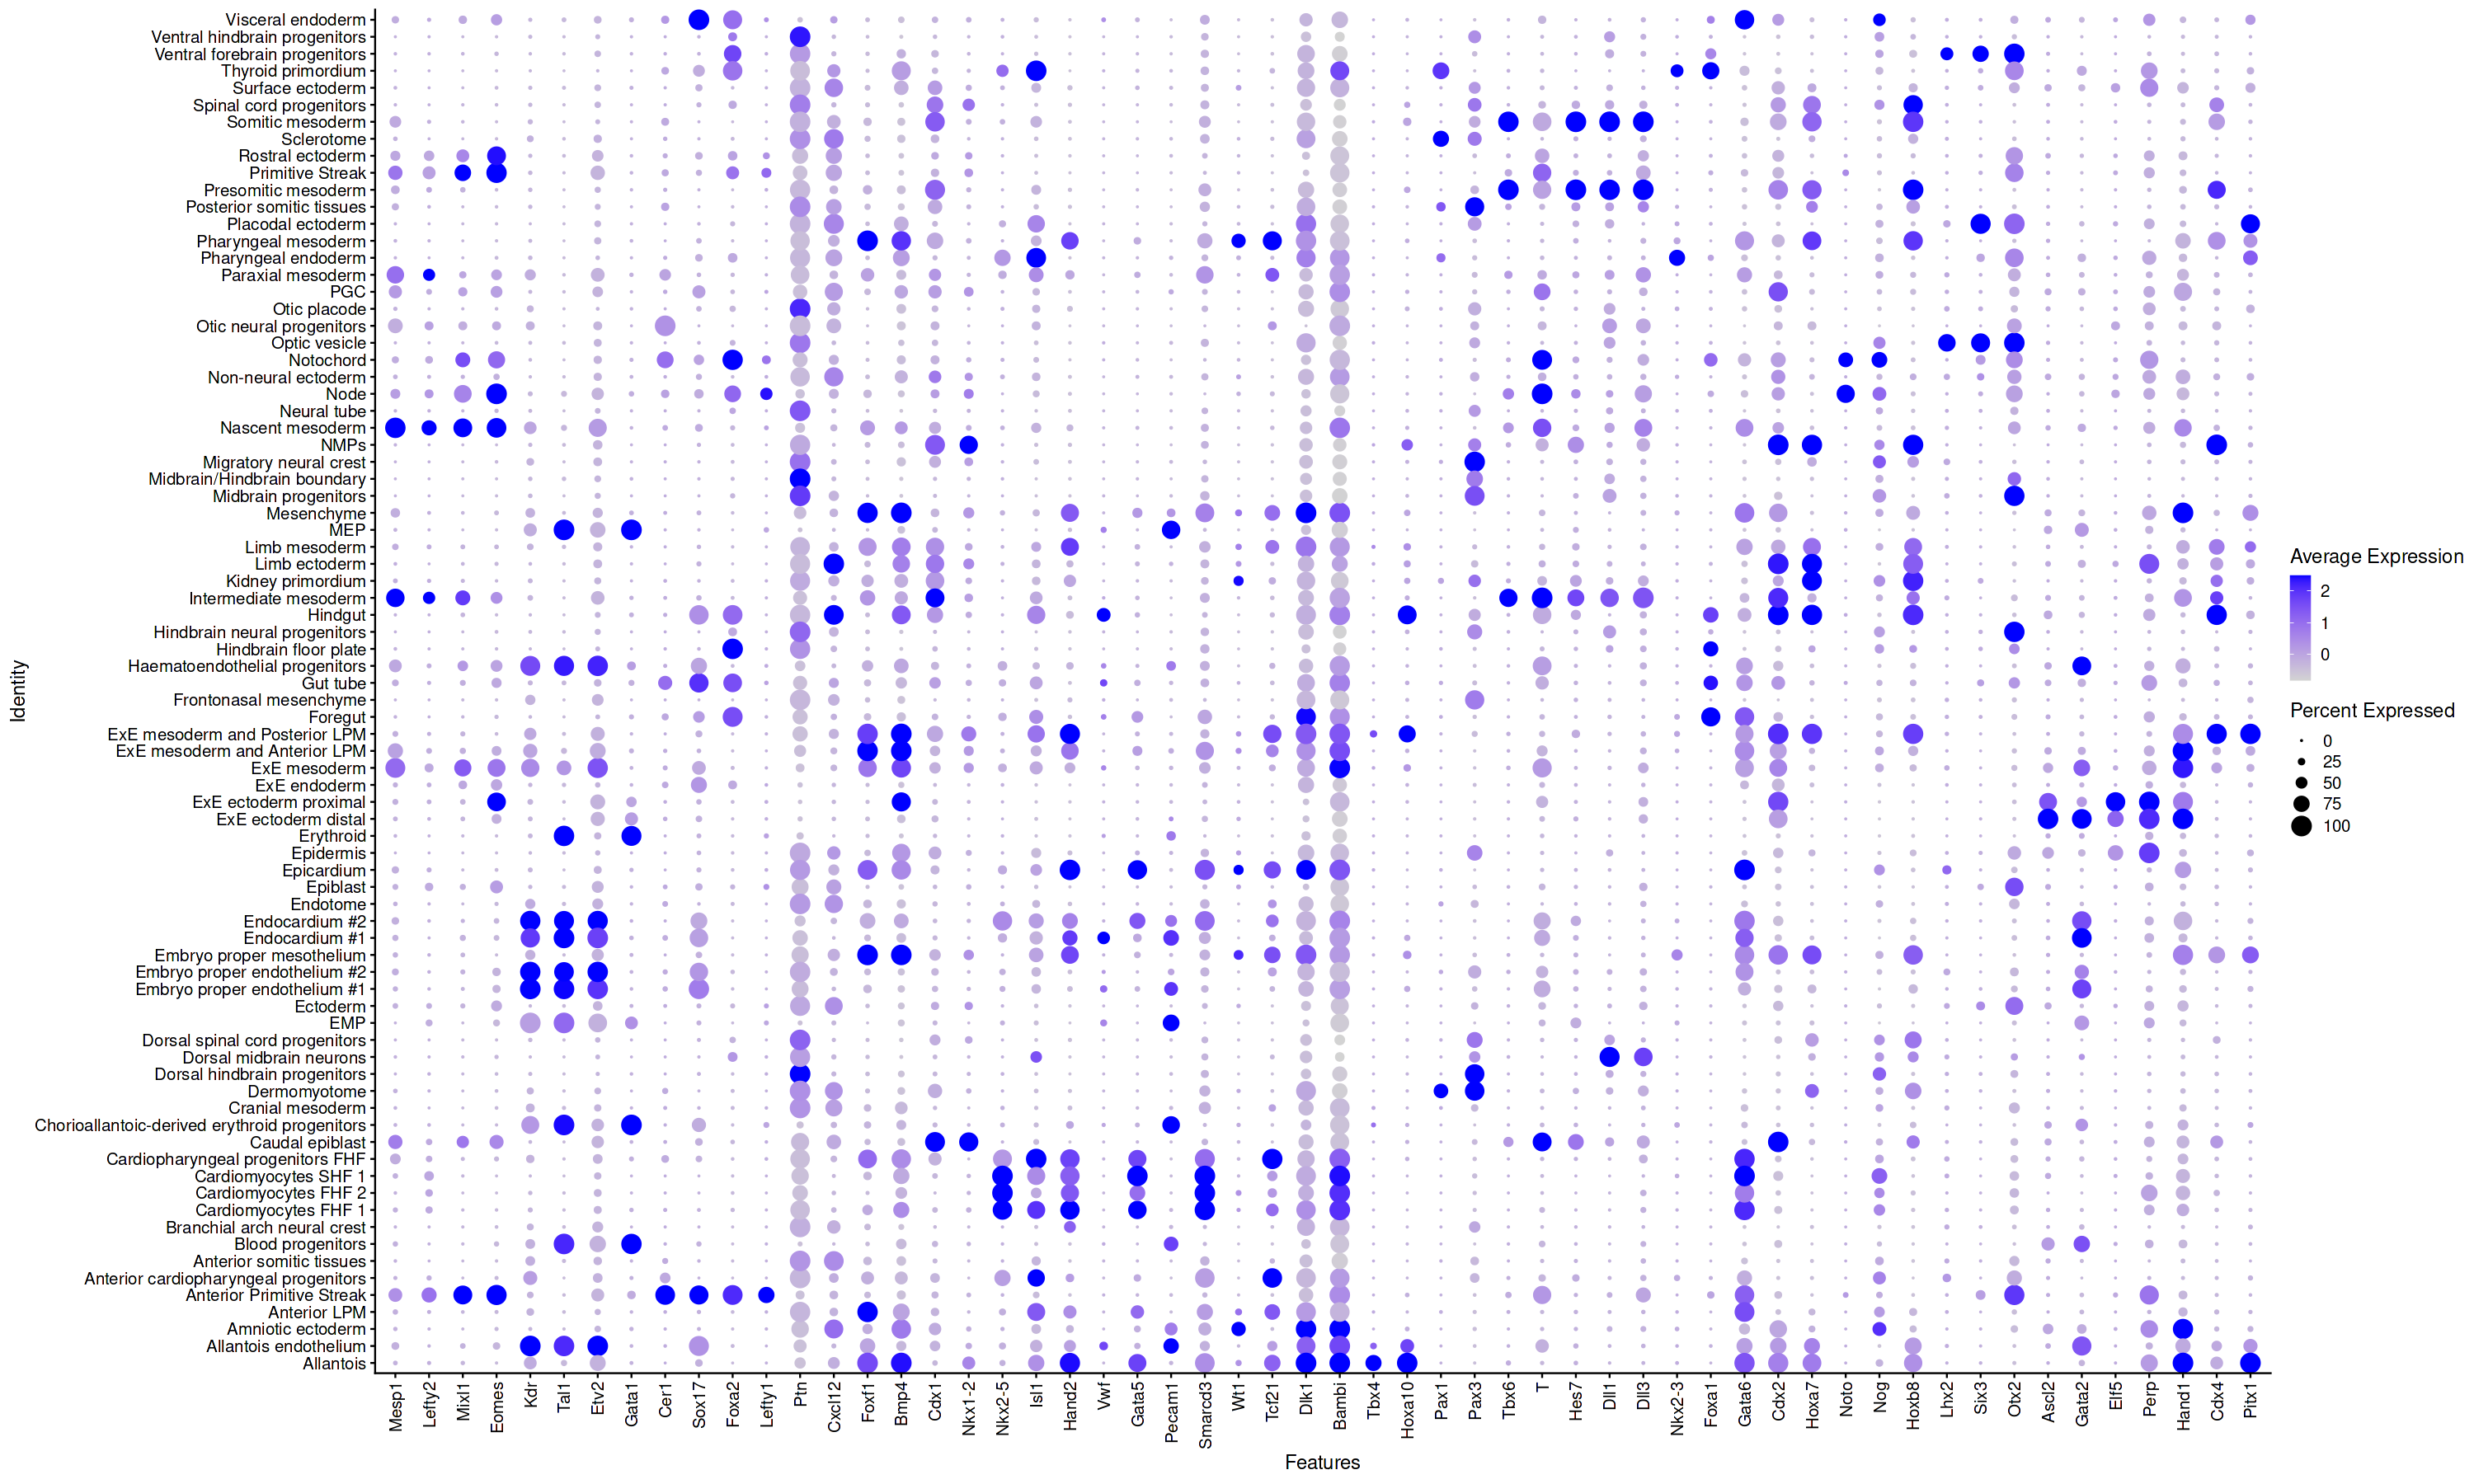

In [66]:
options(repr.plot.width=25, repr.plot.height=15)
DotPlot(seurat_combined_seqFISH_post_QC, 
        group.by = "refined_annotation", 
        features = genes_to_plot, 
        assay = "imputed") +
  theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust = 1))

## Make Distinct Colors for High Resolution Clusters

In [67]:
library(RColorBrewer)
library(colorspace)

# Define your unique cluster_subcluster values
unique_clusters <- unique(FINAL_REFINED_ANNOTATIONS$cluster_subcluster)
print(unique_clusters)  # Display the unique values

# Extract main clusters (before the dot, e.g., "0" from "0.10", "0.8")
clusters <- gsub("\\..*", "", unique_clusters)

# Get unique main clusters
unique_main_clusters <- unique(clusters)

# Generate distinct colors for main clusters
n_colors <- length(unique_main_clusters)

# Ensure enough colors using colorRampPalette
if (n_colors <= 12) {
  palette_colors <- brewer.pal(n_colors, "Set3")  # Use Set3 for distinct colors (max 12)
} else {
  palette_colors <- colorRampPalette(brewer.pal(12, "Set3"))(n_colors)  # Expand colors if needed
}

# Assign colors to main clusters
main_cluster_colors <- setNames(palette_colors, unique_main_clusters)

# Assign shades to subclusters
assigned_colors <- sapply(unique_clusters, function(cluster_subcluster) {
  main_cluster <- gsub("\\..*", "", cluster_subcluster)  # Extract main cluster
  base_color <- main_cluster_colors[main_cluster]  # Get base color
  subcluster_index <- as.numeric(gsub(".*\\.", "", cluster_subcluster))  # Extract subcluster index
  subcluster_index[is.na(subcluster_index)] <- 0  # Handle cases without subcluster (e.g., "5")

  # Adjust color brightness using colorspace package
  adjust_factor <- 0.2 - (subcluster_index * 0.05)  # Adjust factor for shades
  if (adjust_factor >= 0) {
    adjusted_color <- lighten(base_color, adjust_factor)
  } else {
    adjusted_color <- darken(base_color, abs(adjust_factor))
  }

  return(adjusted_color)
})

# Convert to named character vector
color_vector <- setNames(assigned_colors, unique_clusters)

  [1] "0.10"  "0.8"   "0.0"   "24.3"  "17.11" "1.11"  "5.3"   "9.4"   "60.1" 
 [10] "1.14"  "5.6"   "12.10" "16.6"  "54.3"  "34.1"  "22.3"  "25.8"  "29.4" 
 [19] "48.10" "15.10" "3.10"  "3.7"   "42.3"  "8.4"   "34.3"  "6.1"   "40.1" 
 [28] "8.8"   "13.6"  "10.1"  "7.8"   "18.8"  "20.2"  "7.4"   "15.1"  "3.8"  
 [37] "30.4"  "14.10" "4.2"   "30.3"  "20.9"  "16.4"  "1.7"   "23.1"  "15.5" 
 [46] "51.4"  "7.5"   "32.4"  "10.11" "4.3"   "10.5"  "40.4"  "20.1"  "18.9" 
 [55] "54.4"  "56.6"  "12.1"  "1.10"  "25.5"  "4.13"  "3.4"   "17.1"  "12.12"
 [64] "30.8"  "1.8"   "12.6"  "18.3"  "39.3"  "3.3"   "37.3"  "34.6"  "11.6" 
 [73] "20.8"  "6.7"   "14.2"  "15.2"  "32.3"  "7.3"   "4.10"  "5.1"   "13.10"
 [82] "26.8"  "26.0"  "23.2"  "43.1"  "62.7"  "21.11" "42.11" "5.0"   "8.1"  
 [91] "23.8"  "0.15"  "48.8"  "1.3"   "10.12" "9.12"  "1.12"  "3.5"   "5.8"  
[100] "5.7"   "24.13" "13.11" "39.5"  "25.2"  "5.4"   "18.2"  "26.2"  "18.5" 
[109] "15.12" "34.0"  "36.1"  "7.13"  "11.14" "10.13" "39.2"  "6

In [68]:
head(color_vector)

0.10       0.8       0.0      24.3     17.11      1.11 
"#3D9487" "#63A79C" "#99DED2" "#A2DCC5" "#4A9562" "#619947"

In [69]:
# Generate intermediate less saturated colors
distinct_colors <- c(
  "0" = "#C0392B", "1" = "#E67E22", "2" = "#F1C40F", "3" = "#27AE60", "4" = "#2980B9",
  "5" = "#8E44AD", "6" = "#D35400", "7" = "#F39C12", "8" = "#16A085", "9" = "#3498DB",
  "10" = "#9B59B6", "11" = "#7F8C8D", "12" = "#E74C3C", "13" = "#E67E22", "14" = "#F1C40F",
  "15" = "#1ABC9C", "16" = "#2ECC71", "17" = "#3498DB", "18" = "#9B59B6", "19" = "#C0392B",
  "20" = "#E74C3C", "21" = "#E67E22", "22" = "#F1C40F", "23" = "#1ABC9C", "24" = "#2ECC71",
  "25" = "#3498DB", "26" = "#9B59B6", "27" = "#A52A2A", "28" = "#E74C3C", "29" = "#E67E22",
  "30" = "#D2B48C", "31" = "#808080", "32" = "#FFC0CB", "33" = "#BDB76B", "34" = "#FFD700",
  "35" = "#00FA9A", "36" = "#4682B4", "37" = "#6A5ACD", "38" = "#9932CC", "39" = "#8B4513",
  "40" = "#DC143C", "41" = "#FF8C00", "42" = "#DAA520", "43" = "#ADFF2F", "44" = "#20B2AA",
  "45" = "#40E0D0", "46" = "#7B68EE", "47" = "#BA55D3", "48" = "#CD853F", "49" = "#BC8F8F",
  "50" = "#DB7093", "51" = "#D2691E", "52" = "#FF1493", "53" = "#7FFFD4", "54" = "#B8860B",
  "55" = "#556B2F", "56" = "#8FBC8F", "57" = "#48D1CC", "58" = "#9400D3", "59" = "#8B0000",
  "60" = "#FFDAB9", "61" = "#CD5C5C", "62" = "#FF4500", "63" = "#F4A460", "64" = "#DDA0DD"
)

## Generate Videos

In [70]:
marker_genes_list <- Harland_marker_genes_list

In [71]:
# Extract only the genes present in `marker_genes_list`
selected_genes <- unique(unlist(marker_genes_list))

valid_selected_genes <- intersect(selected_genes, rownames(GetAssayData(seurat_combined_seqFISH_post_QC, assay = "imputed")))

if (length(valid_selected_genes) == 0) {
  stop("No valid genes found in the imputed assay.")
}

gene_expression_data <- GetAssayData(seurat_combined_seqFISH_post_QC, slot = "data", assay = "imputed")[valid_selected_genes, ]

# prepare the gene expression data as a data table

gene_expression_data_t <- t(gene_expression_data)
gene_expression_data_t <- as.data.frame(gene_expression_data_t)
gene_expression_data_t$cell_ID <- rownames(gene_expression_data_t)

# generate subset dataframe to merge
gene_expression_seqFISH_meta <- subset(df_total, select = c(dim_1, dim_2, dim_3, embryo_name_updated_sf, UMAP_1, UMAP_2, refined_annotation, passed_QC, stage_alignment_pass_QC, joint_clusters_pass_QC, cell_ID))

# Merge data frames, keeping only overlapping rows based on cell_ID
gene_expression_df <- inner_join(gene_expression_seqFISH_meta, gene_expression_data_t, by = "cell_ID")
rownames(gene_expression_df) <- gene_expression_df$cell_ID

In [72]:
refined_annotation_colors <- Harland_colors

In [73]:
table(df_total$joint_clusters_pass_QC)


FALSE  TRUE 
 1483 61705 

In [74]:
# Load required libraries
library(ggplot2)
library(patchwork)  # For arranging multiple plots
library(dplyr)

# Define output directory
output_dir <- "projects/03_seqFISH_FINAL/code/CELL_GENOMICS_REVISIONS/GITHUB_UPLOAD_FOLDER/6_figure_generation/supp_videos/output"

# Ensure the directory exists
if (!dir.exists(output_dir)) {
  dir.create(output_dir, recursive = TRUE)
}

# Define function to generate a plot for a specific cell type (e.g., "Allantois")
generate_celltype_plot <- function(embryo_number, selected_annotation, df_total, refined_annotation_colors, pt_sz_1 = 0.5, pt_sz_2 = 1.2) {
  df_background <- subset(df_total, embryo_name_updated_sf %in% embryo_number)  # Background cells
  df_highlight <- subset(df_total, refined_annotation == selected_annotation & joint_clusters_pass_QC == TRUE & embryo_name_updated_sf %in% embryo_number)

  p <- ggplot() + 
    geom_point(data = df_background, aes(dim_1, dim_2), col = '#E0E0E0', size = pt_sz_1) +
    geom_point(data = df_highlight, aes(dim_1, dim_2, color = refined_annotation), size = pt_sz_2) +
    scale_color_manual(values = refined_annotation_colors) + 
    theme_void() + 
    theme(legend.position = 'none') + 
    coord_fixed(ratio = 1)
  
  return(p)
}

# Define function to generate gene expression plot (shared scale across embryos, no legend)
generate_gene_plot <- function(embryo_number, gene_to_plot, df_total, gene_expression_df, min_expr, max_expr, pt_sz_1 = 0.5, pt_sz_2 = 1.2) {
  df_background <- subset(df_total, embryo_name_updated_sf %in% embryo_number)  # Background cells
  df_highlight <- subset(gene_expression_df, joint_clusters_pass_QC == TRUE & embryo_name_updated_sf %in% embryo_number)

  # Ensure the gene exists
  if (!gene_to_plot %in% colnames(df_highlight)) {
    stop(paste("Error: Gene", gene_to_plot, "not found in gene_expression_df"))
  }

  # Order by gene expression (low → high)
  df_highlight <- df_highlight %>% arrange(!!sym(gene_to_plot))

  p <- ggplot() + 
    geom_point(data = df_background, aes(dim_1, dim_2), col = '#E0E0E0', size = pt_sz_1) +
    geom_point(data = df_highlight, aes(dim_1, dim_2, color = !!sym(gene_to_plot)), size = pt_sz_2) +
    scale_color_gradient(
      low = "#E0E0E0", high = "#00008B", limits = c(min_expr, max_expr)  # Ensures same scale
    ) +
    theme_void() + 
    theme(legend.position = 'none') +  # Remove legend
    coord_fixed(ratio = 1)

  return(p)
}

# Define cell type to highlight
selected_celltype <- "Allantois"

# Define genes to plot
genes_to_plot <- c("Tbx4", "Hoxa10")

# Compute global gene expression min/max across all embryos for consistent scaling
min_expr_values <- sapply(genes_to_plot, function(gene) min(gene_expression_df[[gene]], na.rm = TRUE))
max_expr_values <- sapply(genes_to_plot, function(gene) max(gene_expression_df[[gene]], na.rm = TRUE))

# Generate label plots with adjustable font size
generate_label_plot <- function(text_label, font_size = 4) {
  ggplot() +
    annotate("text", x = 1, y = 1, label = text_label, size = font_size, fontface = "bold", angle = 90, hjust = 0.5, vjust = 0.5) +
    theme_void()
}

p_label_allantois <- generate_label_plot("Allantois", font_size = 5)
p_label_tb <- generate_label_plot("Tbx4", font_size = 5)
p_label_hx10 <- generate_label_plot("Hoxa10", font_size = 5)
p_label_hx11 <- generate_label_plot("Hoxa11", font_size = 5)

# Generate plots for "Allantois" in each embryo
p1_allantois <- generate_celltype_plot("1", selected_celltype, df_total, refined_annotation_colors)
p2_allantois <- generate_celltype_plot("2", selected_celltype, df_total, refined_annotation_colors)
p3_allantois <- generate_celltype_plot("3", selected_celltype, df_total, refined_annotation_colors)
p4_allantois <- generate_celltype_plot("4", selected_celltype, df_total, refined_annotation_colors)
p5_allantois <- generate_celltype_plot("5", selected_celltype, df_total, refined_annotation_colors)
p6_allantois <- generate_celltype_plot("6", selected_celltype, df_total, refined_annotation_colors)
p7_allantois <- generate_celltype_plot("7", selected_celltype, df_total, refined_annotation_colors)

# Generate gene expression plots
generate_gene_plots <- function(gene) {
  list(
    generate_gene_plot("1", gene, df_total, gene_expression_df, min_expr_values[gene], max_expr_values[gene]),
    generate_gene_plot("2", gene, df_total, gene_expression_df, min_expr_values[gene], max_expr_values[gene]),
    generate_gene_plot("3", gene, df_total, gene_expression_df, min_expr_values[gene], max_expr_values[gene]),
    generate_gene_plot("4", gene, df_total, gene_expression_df, min_expr_values[gene], max_expr_values[gene]),
    generate_gene_plot("5", gene, df_total, gene_expression_df, min_expr_values[gene], max_expr_values[gene]),
    generate_gene_plot("6", gene, df_total, gene_expression_df, min_expr_values[gene], max_expr_values[gene]),
    generate_gene_plot("7", gene, df_total, gene_expression_df, min_expr_values[gene], max_expr_values[gene])
  )
}

gene_plots_tb <- generate_gene_plots("Tbx4")
gene_plots_hx10 <- generate_gene_plots("Hoxa10")
gene_plots_hx11 <- generate_gene_plots("Hoxa10")

# Arrange all plots with left-side rotated labels
final_plot <- (
  p_label_allantois | p1_allantois | p2_allantois | p3_allantois | p4_allantois | p5_allantois | p6_allantois | p7_allantois) /
  (p_label_tb | gene_plots_tb[[1]] | gene_plots_tb[[2]] | gene_plots_tb[[3]] | gene_plots_tb[[4]] | gene_plots_tb[[5]] | gene_plots_tb[[6]] | gene_plots_tb[[7]]) /
  (p_label_hx10 | gene_plots_hx10[[1]] | gene_plots_hx10[[2]] | gene_plots_hx10[[3]] | gene_plots_hx10[[4]] | gene_plots_hx10[[5]] | gene_plots_hx10[[6]] | gene_plots_hx10[[7]]) /
  (p_label_hx11 | gene_plots_hx11[[1]] | gene_plots_hx11[[2]] | gene_plots_hx11[[3]] | gene_plots_hx11[[4]] | gene_plots_hx11[[5]] | gene_plots_hx11[[6]] | gene_plots_hx11[[7]])

# Save the final plot
output_file <- paste0(output_dir, "Allantois_Tbx4_Hoxa10_Hoxa11.png")
ggsave(output_file, final_plot, width = 16, height = 14, dpi = 300)

print("Final plot saved!")

[1] "Final plot saved!"


In [75]:
# Define function to generate a plot for a specific cell type (e.g., "Allantois")
generate_cluster_plot <- function(embryo_number, selected_annotation, df_total, refined_annotation_colors, pt_sz_1 = 0.5, pt_sz_2 = 1.2) {
  df_background <- subset(df_total, embryo_name_updated_sf %in% embryo_number)  # Background cells
  df_highlight <- subset(df_total, refined_annotation == selected_annotation & embryo_name_updated_sf %in% embryo_number)

  p <- ggplot() + 
    geom_point(data = df_background, aes(dim_1, dim_2), col = '#E0E0E0', size = pt_sz_1) +
    geom_point(data = df_highlight, aes(dim_1, dim_2, color = cluster_subcluster), size = pt_sz_2) +
    scale_color_manual(values = color_vector) + 
    theme_void() + 
    theme(legend.position = 'none') + 
    coord_fixed(ratio = 1)
  
  return(p)
}

In [76]:
# Load required libraries
library(ggplot2)
library(patchwork)  # For arranging multiple plots
library(dplyr)

# Define base output directory
base_output_dir <- "projects/03_seqFISH_FINAL/code/CELL_GENOMICS_REVISIONS/GITHUB_UPLOAD_FOLDER/6_figure_generation/supp_videos/output"

# Define category-specific subdirectories
category_dirs <- list(
  "LPM" = file.path(base_output_dir, "LPM"),
  "Cranial_Somitic" = file.path(base_output_dir, "Cranial_Somitic"),
  "Hematovascular" = file.path(base_output_dir, "Hematovascular"),
  "Endoderm" = file.path(base_output_dir, "Endoderm"),
  "Surface_Ectoderm" = file.path(base_output_dir, "Surface_Ectoderm"),
  "Neural_Tube" = file.path(base_output_dir, "Neural_Tube"),
  "Early_Gastrula" = file.path(base_output_dir, "Early_Gastrula"),
  "Other" = file.path(base_output_dir, "Other")  # Default category if not in lists
)

# Ensure all directories exist
lapply(category_dirs, function(dir) if (!dir.exists(dir)) dir.create(dir, recursive = TRUE))

# Function to determine the output directory for each cell type
get_output_directory <- function(celltype) {
  if (celltype %in% LPM) return(category_dirs$LPM)
  if (celltype %in% cranial_somitic) return(category_dirs$Cranial_Somitic)
  if (celltype %in% hematovascular) return(category_dirs$Hematovascular)
  if (celltype %in% endoderm) return(category_dirs$Endoderm)
  if (celltype %in% surface_ectoderm) return(category_dirs$Surface_Ectoderm)
  if (celltype %in% neural_tube) return(category_dirs$Neural_Tube)
  if (celltype %in% early_gastrula) return(category_dirs$Early_Gastrula)
  return(category_dirs$Other)  # Default if not found in any list
}

# Function to generate title slide with a white background and same dimensions as other plots
generate_title_slide <- function(title_text) {
  ggplot() +
    annotate("text", x = 1, y = 1, label = title_text, size = 10, fontface = "bold", hjust = 0.5, vjust = 0.5) +
    theme_void() +
    theme(plot.background = element_rect(fill = "white", color = "white"))
}

# **Create a title slide for each folder before adding cell type plots**
for (folder_name in names(category_dirs)) {
  folder_path <- category_dirs[[folder_name]]
  title_plot <- generate_title_slide(paste("Category:", folder_name))

  title_output_file <- file.path(folder_path, paste0("TitleSlide_", folder_name, ".png"))
  ggsave(title_output_file, title_plot, width = 16, height = 16, dpi = 300, bg = "white")
}

# Iterate through all cell types in marker_genes_list
for (celltype in names(marker_genes_list)) {
  
  marker_genes <- marker_genes_list[[celltype]]
  marker_genes <- marker_genes[marker_genes %in% colnames(gene_expression_df)]
  marker_genes <- marker_genes[1:min(2, length(marker_genes))]  # Select up to 2 genes

  if (length(marker_genes) == 0) next  

  min_expr_values <- sapply(marker_genes, function(gene) {
    if (gene %in% colnames(gene_expression_df)) {
      min(gene_expression_df[[gene]], na.rm = TRUE)
    } else { NA }
  })

  max_expr_values <- sapply(marker_genes, function(gene) {
    if (gene %in% colnames(gene_expression_df)) {
      max(gene_expression_df[[gene]], na.rm = TRUE)
    } else { NA }
  })

  valid_genes <- !is.na(min_expr_values) & !is.na(max_expr_values)
  marker_genes <- marker_genes[valid_genes]
  min_expr_values <- min_expr_values[valid_genes]
  max_expr_values <- max_expr_values[valid_genes]

  # **Generate label plots**
  p_label_celltype <- generate_label_plot(celltype)
  p_label_genes <- lapply(marker_genes, generate_label_plot)

  # **Generate plots for each embryo**
  cluster_plots <- lapply(1:7, function(i) {
    generate_cluster_plot(as.character(i), celltype, df_total, color_vector)
  })

  celltype_plots <- lapply(1:7, function(i) {
    generate_celltype_plot(as.character(i), celltype, df_total, refined_annotation_colors)
  })

  gene_plots <- lapply(marker_genes, function(gene) {
    lapply(1:7, function(i) {
      generate_gene_plot(as.character(i), gene, df_total, gene_expression_df, min_expr_values[gene], max_expr_values[gene])
    })
  })

  # **Construct plot rows dynamically, ensuring no NULL entries**
  plot_rows <- list(
    # **Top row: Refined Annotation (Cell Type)**
    wrap_plots(p_label_celltype, celltype_plots[[1]], celltype_plots[[2]], celltype_plots[[3]], 
               celltype_plots[[4]], celltype_plots[[5]], celltype_plots[[6]], celltype_plots[[7]], ncol = 8)
  )

  # **Second row: First Marker Gene**
  if (length(marker_genes) > 0) {
    plot_rows <- append(plot_rows, list(
      wrap_plots(p_label_genes[[1]], gene_plots[[1]][[1]], gene_plots[[1]][[2]], gene_plots[[1]][[3]], 
                 gene_plots[[1]][[4]], gene_plots[[1]][[5]], gene_plots[[1]][[6]], gene_plots[[1]][[7]], ncol = 8)
    ))
  }

  # **Third row: Second Marker Gene (if available)**
  if (length(marker_genes) > 1) {
    plot_rows <- append(plot_rows, list(
      wrap_plots(p_label_genes[[2]], gene_plots[[2]][[1]], gene_plots[[2]][[2]], gene_plots[[2]][[3]], 
                 gene_plots[[2]][[4]], gene_plots[[2]][[5]], gene_plots[[2]][[6]], gene_plots[[2]][[7]], ncol = 8)
    ))
  }

  # **Bottom row: Cluster Subclusters**
  plot_rows <- append(plot_rows, list(
    wrap_plots(generate_label_plot("Clusters"), cluster_plots[[1]], cluster_plots[[2]], cluster_plots[[3]], 
               cluster_plots[[4]], cluster_plots[[5]], cluster_plots[[6]], cluster_plots[[7]], ncol = 8)
  ))

  # **Filter out NULL elements before plotting**
  plot_rows <- plot_rows[!sapply(plot_rows, is.null)]

  # **Ensure all objects in plot_rows are ggplot objects**
  if (all(sapply(plot_rows, inherits, "ggplot"))) {
    final_plot <- do.call(wrap_plots, c(plot_rows, list(ncol = 1)))
  } else {
    warning("Some elements in plot_rows are not ggplot objects, skipping this cell type.")
    next  # Skip saving if invalid
  }

  # **Determine the appropriate folder for saving**
  celltype_output_dir <- get_output_directory(celltype)

  # **Ensure the directory exists before saving**
  if (!dir.exists(celltype_output_dir)) dir.create(celltype_output_dir, recursive = TRUE)

  # **Generate clean filename**
  clean_celltype <- gsub("[^A-Za-z0-9_]", "_", celltype)  
  output_file <- file.path(celltype_output_dir, paste0("MarkerPlots_", clean_celltype, ".png"))

  # **Save the final plot**
  ggsave(output_file, final_plot, width = 16, height = 16, dpi = 300)
  
  print(paste("Saved plot for:", celltype, "in directory:", celltype_output_dir))
}

print("All marker gene plots have been successfully generated and saved into categorized folders with title slides!")

$LPM
[1] TRUE

$Cranial_Somitic
[1] TRUE

$Hematovascular
[1] TRUE

$Endoderm
[1] TRUE

$Surface_Ectoderm
[1] TRUE

$Neural_Tube
[1] TRUE

$Early_Gastrula
[1] TRUE

$Other
[1] TRUE

[1] "Saved plot for: Anterior Primitive Streak in directory: projects/03_seqFISH_FINAL/code/CELL_GENOMICS_REVISIONS/GITHUB_UPLOAD_FOLDER/6_figure_generation/supp_videos/output/Endoderm"
[1] "Saved plot for: Parietal endoderm in directory: projects/03_seqFISH_FINAL/code/CELL_GENOMICS_REVISIONS/GITHUB_UPLOAD_FOLDER/6_figure_generation/supp_videos/output/Early_Gastrula"
[1] "Saved plot for: Gut tube in directory: projects/03_seqFISH_FINAL/code/CELL_GENOMICS_REVISIONS/GITHUB_UPLOAD_FOLDER/6_figure_generation/supp_videos/output/Endoderm"
[1] "Saved plot for: ExE endoderm in directory: projects/03_seqFISH_FINAL/code/CELL_GENOMICS_REVISIONS/GITHUB_UPLOAD_FOLDER/6_figure_generation/supp_videos/output/Endoderm"
[1] "Saved plot for: Visceral endoderm in directory: projects/03_seqFISH_FINAL/code/CELL_GENOMICS_REVISIONS/GITHUB_UPLOAD_FOLDER/6_figure_generation/supp_videos/output/Endoderm"
[1] "Saved plot for: ExE ectoderm distal in directory: projects/03_seqFISH_FINAL/code/CELL_GENOMICS_REVISIONS/

## Update Only One Cell Type at a Time

In [77]:
# Load required libraries
library(ggplot2)
library(patchwork)  # For arranging multiple plots
library(dplyr)

# Define the cell type you wish to generate plots for
selected_celltype <- "Thyroid primordium"  # Specify the desired cell type here (e.g., "LPM")

# Define base output directory
base_output_dir <- "projects/03_seqFISH_FINAL/code/CELL_GENOMICS_REVISIONS/GITHUB_UPLOAD_FOLDER/6_figure_generation/supp_videos/output"

# Define category-specific subdirectories
category_dirs <- list(
  "LPM" = file.path(base_output_dir, "LPM"),
  "Cranial_Somitic" = file.path(base_output_dir, "Cranial_Somitic"),
  "Hematovascular" = file.path(base_output_dir, "Hematovascular"),
  "Endoderm" = file.path(base_output_dir, "Endoderm"),
  "Surface_Ectoderm" = file.path(base_output_dir, "Surface_Ectoderm"),
  "Neural_Tube" = file.path(base_output_dir, "Neural_Tube"),
  "Early_Gastrula" = file.path(base_output_dir, "Early_Gastrula"),
  "Other" = file.path(base_output_dir, "Other")  # Default category if not in lists
)

# Ensure all directories exist
lapply(category_dirs, function(dir) if (!dir.exists(dir)) dir.create(dir, recursive = TRUE))

# Function to determine the output directory for each cell type
get_output_directory <- function(celltype) {
  if (celltype %in% LPM) return(category_dirs$LPM)
  if (celltype %in% cranial_somitic) return(category_dirs$Cranial_Somitic)
  if (celltype %in% hematovascular) return(category_dirs$Hematovascular)
  if (celltype %in% endoderm) return(category_dirs$Endoderm)
  if (celltype %in% surface_ectoderm) return(category_dirs$Surface_Ectoderm)
  if (celltype %in% neural_tube) return(category_dirs$Neural_Tube)
  if (celltype %in% early_gastrula) return(category_dirs$Early_Gastrula)
  return(category_dirs$Other)  # Default if not found in any list
}

# Function to generate title slide with a white background and same dimensions as other plots
generate_title_slide <- function(title_text) {
  ggplot() +
    annotate("text", x = 1, y = 1, label = title_text, size = 10, fontface = "bold", hjust = 0.5, vjust = 0.5) +
    theme_void() +
    theme(plot.background = element_rect(fill = "white", color = "white"))
}

# **Generate plots only for the selected cell type**
if (selected_celltype %in% names(marker_genes_list)) {

  marker_genes <- marker_genes_list[[selected_celltype]]
  marker_genes <- marker_genes[marker_genes %in% colnames(gene_expression_df)]
  marker_genes <- marker_genes[1:min(2, length(marker_genes))]  # Select up to 2 genes

  if (length(marker_genes) == 0) stop(paste("No marker genes found for", selected_celltype))

  min_expr_values <- sapply(marker_genes, function(gene) {
    if (gene %in% colnames(gene_expression_df)) {
      min(gene_expression_df[[gene]], na.rm = TRUE)
    } else { NA }
  })

  max_expr_values <- sapply(marker_genes, function(gene) {
    if (gene %in% colnames(gene_expression_df)) {
      max(gene_expression_df[[gene]], na.rm = TRUE)
    } else { NA }
  })

  valid_genes <- !is.na(min_expr_values) & !is.na(max_expr_values)
  marker_genes <- marker_genes[valid_genes]
  min_expr_values <- min_expr_values[valid_genes]
  max_expr_values <- max_expr_values[valid_genes]

  # **Generate label plots**
  p_label_celltype <- generate_label_plot(selected_celltype)
  p_label_genes <- lapply(marker_genes, generate_label_plot)

  # **Generate plots for each embryo**
  cluster_plots <- lapply(1:7, function(i) {
    generate_cluster_plot(as.character(i), selected_celltype, df_total, color_vector)
  })

  celltype_plots <- lapply(1:7, function(i) {
    generate_celltype_plot(as.character(i), selected_celltype, df_total, refined_annotation_colors)
  })

  gene_plots <- lapply(marker_genes, function(gene) {
    lapply(1:7, function(i) {
      generate_gene_plot(as.character(i), gene, df_total, gene_expression_df, min_expr_values[gene], max_expr_values[gene])
    })
  })

  # **Construct plot rows dynamically, ensuring no NULL entries**
  plot_rows <- list(
    wrap_plots(p_label_celltype, celltype_plots[[1]], celltype_plots[[2]], celltype_plots[[3]], 
               celltype_plots[[4]], celltype_plots[[5]], celltype_plots[[6]], celltype_plots[[7]], ncol = 8)
  )

  if (length(marker_genes) > 0) {
    plot_rows <- append(plot_rows, list(
      wrap_plots(p_label_genes[[1]], gene_plots[[1]][[1]], gene_plots[[1]][[2]], gene_plots[[1]][[3]], 
                 gene_plots[[1]][[4]], gene_plots[[1]][[5]], gene_plots[[1]][[6]], gene_plots[[1]][[7]], ncol = 8)
    ))
  }

  if (length(marker_genes) > 1) {
    plot_rows <- append(plot_rows, list(
      wrap_plots(p_label_genes[[2]], gene_plots[[2]][[1]], gene_plots[[2]][[2]], gene_plots[[2]][[3]], 
                 gene_plots[[2]][[4]], gene_plots[[2]][[5]], gene_plots[[2]][[6]], gene_plots[[2]][[7]], ncol = 8)
    ))
  }

  # Bottom row: Cluster Subclusters
  plot_rows <- append(plot_rows, list(
    wrap_plots(generate_label_plot("Clusters"), cluster_plots[[1]], cluster_plots[[2]], cluster_plots[[3]], 
               cluster_plots[[4]], cluster_plots[[5]], cluster_plots[[6]], cluster_plots[[7]], ncol = 8)
  ))

  # Filter out NULL elements before plotting
  plot_rows <- plot_rows[!sapply(plot_rows, is.null)]

  # Ensure all objects in plot_rows are ggplot objects
  if (all(sapply(plot_rows, inherits, "ggplot"))) {
    final_plot <- do.call(wrap_plots, c(plot_rows, list(ncol = 1)))
  } else {
    warning("Some elements in plot_rows are not ggplot objects, skipping this cell type.")
    next  # Skip saving if invalid
  }

  # Determine the appropriate folder for saving
  celltype_output_dir <- get_output_directory(selected_celltype)

  # Ensure the directory exists before saving
  if (!dir.exists(celltype_output_dir)) dir.create(celltype_output_dir, recursive = TRUE)

  # Generate clean filename
  clean_celltype <- gsub("[^A-Za-z0-9_]", "_", selected_celltype)  
  output_file <- file.path(celltype_output_dir, paste0("MarkerPlots_", clean_celltype, ".png"))

  # Save the final plot
  ggsave(output_file, final_plot, width = 16, height = 16, dpi = 300)
  
  print(paste("Saved plot for:", selected_celltype, "in directory:", celltype_output_dir))
} else {
  print(paste("Selected cell type", selected_celltype, "not found in marker_genes_list."))
}

print("Marker gene plot has been successfully generated and saved!")

$LPM
NULL

$Cranial_Somitic
NULL

$Hematovascular
NULL

$Endoderm
NULL

$Surface_Ectoderm
NULL

$Neural_Tube
NULL

$Early_Gastrula
NULL

$Other
NULL

[1] "Saved plot for: Thyroid primordium in directory: projects/03_seqFISH_FINAL/code/CELL_GENOMICS_REVISIONS/GITHUB_UPLOAD_FOLDER/6_figure_generation/supp_videos/output/Endoderm"
[1] "Marker gene plot has been successfully generated and saved!"


## Print out Package Versions

In [78]:
sessionInfo()

R version 4.2.1 (2022-06-23)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Ubuntu 20.04.5 LTS

Matrix products: default
BLAS:   /usr/lib/x86_64-linux-gnu/openblas-pthread/libblas.so.3
LAPACK: /usr/lib/x86_64-linux-gnu/openblas-pthread/liblapack.so.3

locale:
 [1] LC_CTYPE=C.UTF-8    LC_NUMERIC=C        LC_TIME=C          
 [4] LC_COLLATE=C        LC_MONETARY=C       LC_MESSAGES=C      
 [7] LC_PAPER=C          LC_NAME=C           LC_ADDRESS=C       
[10] LC_TELEPHONE=C      LC_MEASUREMENT=C    LC_IDENTIFICATION=C

attached base packages:
[1] grid      stats4    stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] colorspace_2.1-0            png_0.1-8                  
 [3] Cairo_1.6-0                 gridExtra_2.3              
 [5] ragg_1.2.2                  viridis_0.6.2              
 [7] viridisLite_0.4.1           cowplot_1.1.1              
 [9] ggpubr_0.4.0                batchelor_1.12.3           
[11] pheatmap_1.0.1